# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
P = Project('..')

In [3]:
import urllib.request

import contextily as ctx
import fiona
import igraph
from scipy.spatial import cKDTree
import shapely
import yaml

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/09 09:10:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/09 09:10:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/09 09:10:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Regional boundaries

In [5]:
scales = ['BG', 'Tract', 'County']

## Download data
Note that the TIGER/LINE boundaries and ACS data of the subdivisions of Indiana at different scales were already downloaded in [../../spr_4608/code/1_Geometry_ACS.ipynb](../../spr_4608/code/1_Geometry_ACS.ipynb), but they were for the year 2020 (I think). The files were then directly copied from `$MK/spr_4608/data/geometry` to `$MK/spr_4711/data/acs`.

However, since the UMN access data used the 2010 definitions, they are downloaded explicitly from the Census website.

In [6]:
def download_tiger_boundary(scale, year=2010, state='Indiana', save=True, overwrite=False):
    scale = scale.lower()
    assert scale in ['tabblock', 'bg', 'taz', 'tract', 'county', 'cbsa']
    outfile = P.data / f'boundary/{scale}.parquet'
    if outfile.exists() and not overwrite:
        return
    fips = mk.geo.US_STATES_FIPS[state.upper()]
    year_label = str(year % 2000)
    url = (f'https://www2.census.gov/geo/pvs/tiger{year}st/{fips}_{state}/'
           f'{fips}/tl_{year}_{fips}_{scale}{year_label}.zip')
    if scale == 'taz': url = url.replace('tl_2010', 'tl_2011')
    zipfile = P.data / f'tiger_boundary_{scale}.zip'
    urllib.request.urlretrieve(url, zipfile)
    df = gpd.read_file(zipfile).to_crs(CRS_DEG)
    df = df.rename(columns=lambda x: x.lower().replace(year_label, ''))
    if 'nameslad' in df.columns:
        df = (df.drop(columns='name', errors='ignore')
              .rename(columns={'namelsad': 'name'}))
    cols = ['geoid','name','aland','awater','geometry']
    if not 'name' in df.columns: cols.pop(1)
    df = df[cols]
    if save: df.to_parquet(U.mkfile(outfile))
    zipfile.unlink()
    return df

# download_tiger_boundary('County')

In [7]:
# t=2:14
for scale in tqdm(['County', 'Tract', 'BG', 'TabBlock', 'CBSA', 'TAZ']):
    # print(scale)
    download_tiger_boundary(scale)

  0%|          | 0/6 [00:00<?, ?it/s]

## Combine scales

In [8]:
boundary = pd.concat([
    gpd.read_parquet(P.data / f'boundary/{scale.lower()}.parquet')
    .assign(scale=scale) for scale in scales
]).astype({'geoid': 'category'}).reset_index(drop=True).disp()
boundary.to_parquet(P.data / 'export/boundary.parquet')

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: {"$schema": "https://proj.org/schemas/v0.5/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal comp

geoid    aland   awater  \
     <category>  <int64>  <int64>   
0  181379685003  2566010    39626   

                                            geometry     scale      name  
                                          <geometry>  <object>  <object>  
0  POLYGON ((-85.20815 39.304011, -85.208134 39.3...        BG       NaN

# EPA EJ Screening Tool

## Download data

Download links taken from https://gaftp.epa.gov/EJSCREEN/2022 (directed from the [Download page](https://www.epa.gov/ejscreen/download-ejscreen-data)).

In [9]:
links = [
    '2022_EJSCREEN_BG_Columns.xlsx',
    '2022_EJSCREEN_Supplemental_BG_Columns.xlsx',
    '2022_EJSCREEN_Supplemental_Tract_Columns.xlsx',
    '2022_EJSCREEN_Tract_Columns.xlsx',
    'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI.csv.zip',
    'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI.gdb.zip',
    'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI_Tracts.csv.zip',
    'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI_Tracts.gdb.zip',
    'EJSCREEN_2022_Supplemental_StatePct_with_AS_CNMI_GU_VI.csv.zip',
    'EJSCREEN_2022_Supplemental_StatePct_with_AS_CNMI_GU_VI.gdb.zip',
    'EJSCREEN_2022_Supplemental_StatePct_with_AS_CNMI_GU_VI_Tracts.csv.zip',
    'EJSCREEN_2022_Supplemental_StatePct_with_AS_CNMI_GU_VI_Tracts.gdb.zip',
    'EJSCREEN_2022_Supplemental_with_AS_CNMI_GU_VI.csv.zip',
    'EJSCREEN_2022_Supplemental_with_AS_CNMI_GU_VI.gdb.zip',
    'EJSCREEN_2022_Supplemental_with_AS_CNMI_GU_VI_Tracts.csv.zip',
    'EJSCREEN_2022_Supplemental_with_AS_CNMI_GU_VI_Tracts.gdb.zip',
    'EJSCREEN_2022_with_AS_CNMI_GU_VI.csv.zip',
    'EJSCREEN_2022_with_AS_CNMI_GU_VI.gdb.zip',
    'EJSCREEN_2022_with_AS_CNMI_GU_VI_Tracts.csv.zip',
    'EJSCREEN_2022_with_AS_CNMI_GU_VI_Tracts.gdb.zip',
]

In [10]:
def download_epa_ej(year, fname, root='https://gaftp.epa.gov/EJSCREEN'):
    url = f'{root}/{year}/{fname}'
    fpath = U.mkfile(P.data / f'ejscreen/{fname}')
    urllib.request.urlretrieve(url, fpath)

# %time for link in tqdm(links): download_epa_ej(2022, link) # t=3:25

## Clean data
Important columns described in `{P.data}/ejscreen/variables.csv`.

In [11]:
def clean_ejs_data(save=True, overwrite=False):
    outpath = P.data / 'export/ejscreen.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    df = []
    cols = pd.read_csv(P.data / 'ejscreen/variables.csv')
    for scale, fname in [('Tract', 'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI_Tracts.csv.zip'),
                    ('BG', 'EJSCREEN_2022_StatePct_with_AS_CNMI_GU_VI.csv.zip')]:
        d = pd.read_csv(P.data / f'ejscreen/{fname}', 
                        usecols=['ID', 'STATE_NAME'] + cols['variable'].tolist())
        d = (d.query('STATE_NAME == "Indiana"').drop(columns='STATE_NAME')
             .melt('ID').astype({'ID': str}).rename(columns={'ID': 'geoid'})
             .merge(cols, on='variable').assign(scale=scale))
        df.append(d)
    df = (pd.concat(df).reset_index(drop=True)
        [['scale'] + cols.columns.tolist() + ['geoid', 'value']]
        .astype({x: 'category' for x in ['geoid', 'scale'] + cols.columns.tolist()})
        .drop(columns='variable').rename(columns={'description': 'variable'}))
    if save:
        df.to_parquet(P.data / 'export/ejscreen.parquet')
    return df

%time ejs = clean_ejs_data(overwrite=False) # t=0:07

CPU times: user 109 ms, sys: 36.8 ms, total: 146 ms
Wall time: 50.4 ms


# AAA data
**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

## Download

### [Auto (2018)](https://conservancy.umn.edu/handle/11299/211408)
Data not available for Indiana 😭

### [Transit (2019)](https://conservancy.umn.edu/handle/11299/218072) – Indiana

### [Bike (2019)](https://conservancy.umn.edu/handle/11299/218194) – Indiana

### [Walk (2014)](https://conservancy.umn.edu/handle/11299/173991) – Indianapolis

## Extract layers

In [12]:
def get_aaa_layers(mode, year=2017):
    mode = mode.lower()
    assert mode in ['bike', 'transit']
    fpath = P.data / f'aaa/{mode}/indiana.gpkg'
    year = str(year % 2000)
    for layer in tqdm(fiona.listlayers(fpath)):
        if not layer.startswith(mode[:2] + '_'): continue
        tt = int(layer.split('_')[1])
        df = gpd.read_file(fpath, layer=layer).astype({'blockid': int})
        df = df.set_index('blockid').rename_axis('geoid')
        df = df.filter(like=f'_{year}').astype(np.int32)
        df = df.rename(columns=lambda x: x.replace(f'_{year}', ''))
        df.to_parquet(P.data / f'aaa/{mode}/{tt:02}_min.parquet')
    
# %time x = get_aaa_layers('bike'); x

**TRANSIT**

In [13]:
# get_aaa_layers('transit') # t=9:16

**BIKE**

In [14]:
# get_aaa_layers('bike') # t=8:32

## Categories
**[Columns documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

Chosen variables described in a YAML file: `{P.data}/aaa/lehd_variables.yml`.

In [15]:
with open(P.data / 'aaa/lehd_variables.yml', 'rb') as f:
    lehd_cat_vars = yaml.safe_load(f)

## Get useful info
Description of LODES columns: https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.4.pdf

In [16]:
def get_aaa_tables(scale, mode, tt_thresh, cat_vars=lehd_cat_vars):
    scale, mode = scale.lower(), mode.lower()
    assert scale in ['bg', 'county', 'tract', 'taz']
    assert mode in ['bike', 'transit', 'county']
    df = pd.read_parquet(P.data / f'aaa/{mode}/{tt_thresh:02}_min.parquet')
    digits = dict(block=15, bg=12, tract=11, county=5)[scale]
    df.index = df.index.astype(str).str.slice(0, digits).rename('geoid')
    df = df.groupby('geoid').sum().astype(np.int32)
    res = []
    for is_rac, prefix in [(False, 'w_'), (True, 'r_')]:
        res.append(df.filter(like=prefix).reset_index()
                   .rename(columns=lambda x: x.replace(prefix, ''))
                   .assign(**{'is_rac': is_rac}))
    df = (pd.concat(res).set_index(['is_rac', 'geoid'])
          .fillna(0).astype(np.int32))
    res = []
    for cat, x in cat_vars.items():
        d = df[x.keys()].rename(columns=x)
        d = d.reset_index()
        d = d.melt(['is_rac','geoid'], var_name='subcategory', value_name='num_jobs')
        d['category'] = cat
        res.append(d)
    res = (pd.concat(res).reset_index(drop=True)
           [['is_rac','category','subcategory','geoid','num_jobs']])
    return res

x = get_aaa_tables('bg', 'transit', 30).disp(2)

375,258 rows x 5 cols; Memory: 80.3 MiB


is_rac  category subcategory         geoid num_jobs
   <bool>  <object>    <object>      <object>  <int32>
0   False   Overall       Total  180010301001      620
1   False   Overall       Total  180010301002      783

## Prepare a single file for export

In [17]:
modes = ['Bike', 'Transit']
travel_times = list(range(5, 60+1, 5))

In [18]:
def get_aaa_overall(scales, modes, travel_times, save=True, overwrite=False):
    outfile = P.data / 'export/aaa.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    res = []
    for scale in tqdm(scales):
        for mode in modes:
            for tt in travel_times:
                df = get_aaa_tables(scale, mode, tt)
                df = df.assign(mode=mode, scale=scale, tt_thresh=tt)
                res.append(df)
    df = pd.concat(res).reset_index(drop=True)
    df = df.astype({x: 'category' for x in [
        'category', 'subcategory', 'geoid', 'mode', 'scale', 'tt_thresh']})
    df = df[['scale', 'mode', 'tt_thresh', 'is_rac',
             'category', 'subcategory', 'geoid', 'num_jobs']]
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

%time aaa = get_aaa_overall(scales, modes, travel_times, overwrite=False).disp() # t=1:07

+-----+----+---------+------+--------+-----------+------------+--------+
|scale|mode|tt_thresh|is_rac|category|subcategory|       geoid|num_jobs|
+-----+----+---------+------+--------+-----------+------------+--------+
|   BG|Bike|        5| false| Overall|      Total|180010301001|       8|
+-----+----+---------+------+--------+-----------+------------+--------+
only showing top 1 row

CPU times: user 11.3 ms, sys: 31.6 ms, total: 42.9 ms
Wall time: 5.95 s


# OSM

## Download and clean state database

In [19]:
%%bash
# Last downloaded: Fri, Apr 21, 2023 at 9:56 AM EDT
# mkdir -p ../data/osm
# cd ../data/osm
# mkdir -p raw
# state=indiana
# wget -P raw https://download.geofabrik.de/north-america/us/$state-latest-free.shp.zip # t=0:15
# unzip $state-latest-free.shp.zip -d raw # t=0:13
# rm raw/$state-latest-free.shp.zip

## Clean database
- Convert layers to standard geographical CRS (EPSG 4326)
- Extract info about each layer's geometry type and 
- Export as .parquet files

In [20]:
osm_layers = sorted(['natural','landuse','pofw','pois','railways','traffic',
                     'transport','water','waterways','buildings','roads'])

In [21]:
def clean_osm_layers(layers=osm_layers, inpath=P.data / 'osm/raw',
                     outpath=P.data / 'osm', remove_original=True, overwrite=False):
    layers = tqdm(layers)
    get_path = lambda x: inpath / f'gis_osm_{x}_free_1.shp'
    for layer in layers:
        try:
            layers.set_description(layer)
            outfile = outpath / f'{layer}.parquet'
            if outfile.exists() and not overwrite:
                continue
            df = []
            main_file = get_path(layer)
            other_file = get_path(layer + '_a')
            if main_file.exists():
                df.append(gpd.read_file(main_file))
            if other_file.exists():
                df.append(gpd.read_file(other_file))
            df = pd.concat(df).to_crs(CRS_DEG).rename(columns=str.lower)
            info = {'geometry': df.geometry.geom_type.value_counts().to_dict()}
            if 'fclass' in df.columns:
                info['fclass'] = df['fclass'].value_counts().sort_index().to_dict()
            if 'type' in df.columns:
                info['fclass'] = df['type'].value_counts().sort_index().to_dict()
            df.to_parquet(U.mkfile(outfile))
            if remove_original:
                if main_file.exists(): main_file.unlink()
                if other_file.exists(): other_file.unlink()
        except Exception as e:
            print(f'{layer} --> {e}')
    
%time x = clean_osm_layers() # t=2:14

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 22.3 ms, sys: 13.2 ms, total: 35.5 ms
Wall time: 30.9 ms


# POIs

## SafeGraph

In [22]:
def get_sg_pois(rgn_code=None, root=SAFEGRAPH, main_path='us/poi_211104', 
                supplement_path='us/_old/SafeGraphPlacesGeoSupplementSqFt.csv',
                save=True, overwrite=False):
    outfile = P.data / 'pois/safegraph.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    df = SP.read_csv(sorted(list((root / main_path).glob('*.csv.gz'))), header=True)
    # areas = (SP.read_csv(root / supplement_path, header=True)
    #          .select(F.col('safegraph_place_id').alias('placekey'), 'polygon_class', 
    #                  F.col('area_square_feet').alias('area_sqft')))
    # df = df.join(areas, on='placekey')
    if isinstance(rgn_code, str):
        df = df.filter(f'region == "{rgn_code}"')
    df = df.select('location_name', 'brands', 'top_category', 
                   'sub_category', 'naics_code', 'latitude', 
                   'longitude', 'street_address', 'city')
    if save:
        df.toPandas().to_parquet(U.mkfile(outfile))
    return df
    
x = get_sg_pois('IN'); x # t=0:12

DataFrame[location_name: string, brands: string, top_category: string, sub_category: string, naics_code: string, latitude: string, longitude: string, street_address: string, city: string]

## Combine POIs
Using custom classification of POI categories in both OSM and SafeGraph, stored in `{P.data}/pois/poi_categories.yml`.

In [23]:
with open(P.data / 'pois/poi_categories.yml', 'rb') as f:
    poi_categories = yaml.safe_load(f)

In [24]:
def combine_pois(poi_cats=poi_categories, save=True, overwrite=False):
    outfile = P.data / 'pois/pois.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    osm = gpd.read_parquet(P.data / 'osm/pois.parquet')
    cats_osm = (Seq(cats_osm).explode().rename('osm_category')
                .rename_axis('category').reset_index().dropna())
    osm = osm.merge(cats_osm, left_on='fclass', right_on='osm_category')
    osm.geometry = osm.geometry.apply(lambda x: x.centroid)
    osm = osm.assign(source='OSM').rename(columns={'osm_id': 'poi_id'})
    osm = osm[['source', 'poi_id', 'category', 'geometry']]
    sg = pd.read_parquet(P.data / 'pois/safegraph.parquet')
    sg = sg.assign(source='SafeGraph')
    sg['poi_id'] = [f'sg{x:06}' for x in sg.index]
    cats_sg = (Seq(poi_cats_sg).explode().rename('sg_category')
               .rename_axis('category').reset_index())
    sg = sg.merge(cats_sg, left_on='top_category', right_on='sg_category')
    sg = mk.geo.pdf2gdf(sg, 'longitude', 'latitude', CRS_DEG)
    sg = sg[['source', 'poi_id', 'category', 'geometry']]
    pois = pd.concat([sg, osm]).reset_index(drop=True)
    if save:
        pois.to_parquet(outfile)
    return pois

x = combine_pois().set_crs(CRS_DEG).disp()

86,602 rows x 4 cols; Memory: 16.9 MiB; CRS: EPSG:4326


source    poi_id  category                     geometry
    <object>  <object>  <object>                   <geometry>
0  SafeGraph  sg000001   Medical  POINT (-86.49047 39.155071)

### Visualize

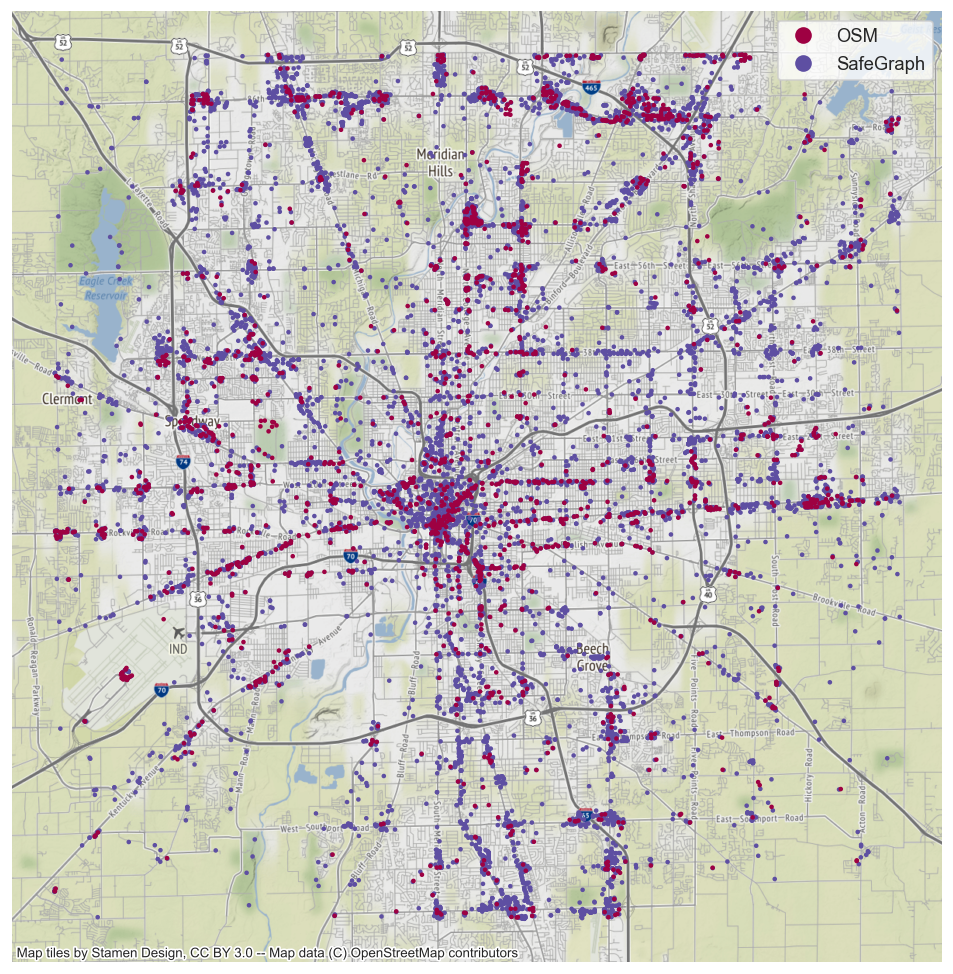

In [25]:
# t=0:07
ax = U.plot(size=(10, 16), dpi=120, axoff=1)
miny, minx = 39.63267237312068, -86.32849758648747
maxy, maxx = 39.92674817390339, -85.9540983877497
x2 = x.cx[minx: maxx, miny: maxy].to_crs(CRS_M)
x2.plot(ax=ax, column='source', cmap='Spectral', legend=True, markersize=3)
ctx.add_basemap(ax=ax, crs=CRS_M);

## POI accessibility

### Create road graph
Nearest neighbor matching based on this [StackExchange answer](https://gis.stackexchange.com/a/301935/220117)

In [26]:
osm_roads_by_mode = {
    'auto': ['motorway', 'motorway_link', 'primary', 'primary_link', 'residential', 'secondary', 
             'secondary_link', 'service', 'tertiary', 'tertiary_link', 'trunk', 'trunk_link', 'unclassified'],
    'bike': ['cycleway', 'footway', 'living_street', 'path', 'residential', 'service', 'unclassified'],
    'walk': ['footway', 'living_street', 'path', 'pedestrian', 'steps', 'track', 'unclassified'],
}

In [27]:
def get_transport_odps(scale, mode, tolerance=100, fclasses=osm_roads_by_mode):
    zones = (gpd.read_parquet(P.data / f'boundary/{scale}.parquet')
             .rename(columns={'geoid': 'pt_id'}).assign(kind='zone')
             .assign(geometry = lambda df: df.to_crs(CRS_M).geometry.centroid))
    zones = Gdf(zones).set_crs(crs=CRS_M)
    pois = (gpd.read_parquet(P.data / 'pois/pois.parquet').to_crs(CRS_M)
            .rename(columns={'poi_id': 'pt_id'}).assign(kind='poi'))
    pts = pd.concat([zones, pois])[['kind', 'pt_id', 'geometry']].astype({'pt_id': str})
    roads = (SP.read_parquet(P.data / 'osm/roads.parquet')
             .select(F.col('osm_id').alias('road_id'), 'fclass', 'geometry')
             .toPandas().pipe(lambda df: df[df['fclass'].isin(fclasses[mode])]))
    roads = (Gdf(roads, geometry=gpd.GeoSeries.from_wkb(roads.geometry))
             .set_crs(CRS_DEG).to_crs(CRS_M))
    return roads

%time x = get_transport_odps('bg', 'auto'); x

CPU times: user 6.08 s, sys: 1.22 s, total: 7.3 s
Wall time: 10.4 s


road_id    fclass  \
0           4450265  motorway   
1           4450420  motorway   
2           4499639  motorway   
3           4499642   primary   
4           4499644  motorway   
...             ...       ...   
1018638  1162571314   service   
1018654  1162607273   primary   
1018670  1162607289   service   
1018671  1162607292   service   
1018674  1162607296   service   

                                                  geometry  
0        LINESTRING (-9552720.344 5121434.428, -9552537...  
1        LINESTRING (-9458870.299 5120561.277, -9458780...  
2        LINESTRING (-9705098.237 5101536.358, -9705004...  
3        LINESTRING (-9704181.632 5102203.353, -9704181...  
4        LINESTRING (-9701965.294 5101489.302, -9701612...  
...                                                    ...  
1018638  LINESTRING (-9462699.133 5118195.800, -9462734...  
1018654  LINESTRING (-9607242.081 5111957.213, -9607258...  
1018670  LINESTRING (-9607243.751 5112087.599, -9607229...  
1018671  LINESTRING (-9607242.983 5112027.480, -9607229...  
1018674  LINESTRING (-9607106.060 5111986.274, -9607096...  

[872704 rows x 3 columns]

In [28]:
def get_road_graph(interpolate_dist=100, save=True, overwrite=False):
    outfile = P.data / 'osm/poi_roads.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    pois = gpd.read_parquet(P.data / 'pois/pois.parquet').to_crs(CRS_M)
    xy_pois = mk.geo.gdf2pdf(pois)
    roads = (SP.read_parquet(P.data / 'osm/roads.parquet')
             .select(F.col('osm_id').alias('road_id'), 'fclass', 'geometry')
             .toPandas())
    roads = (Gdf(roads, geometry=gpd.GeoSeries.from_wkb(roads.geometry))
             .set_crs(CRS_DEG).to_crs(CRS_M))
    def get_dist(line): return np.arange(0, line.length, interpolate_dist)
    def get_pts(line):
        points = [line.interpolate(d) for d in get_dist(line)]
        endpoint = shapely.Point(line.coords[1])
        return points + [endpoint]
    roads['length'] = roads.geometry.length
    roads['pt'] = roads.geometry.apply(get_pts)
    roads['dist'] = roads.geometry.apply(lambda x: get_dist(x).tolist() + [x.length])
    nodes = Gdf(roads.set_index('road_id')[['pt', 'dist']].explode(['pt', 'dist'])
                .rename(columns={'pt': 'geometry'}).reset_index(), crs=CRS_M)
    xy_nodes = mk.geo.gdf2pdf(nodes)
    tree = cKDTree(xy_nodes.values)
    _, idx = tree.query(xy_pois.values)
    nodes = nodes.loc[np.unique(idx)].groupby('road_id').agg({'dist': set})
    nodes = (roads[['road_id', 'length', 'geometry']]
             .merge(nodes, on='road_id', how='left').fillna(''))
    nodes['dist'] = nodes['dist'].apply(set)
    nodes['dist'] = nodes.apply(lambda x: set([0., x['length']]).union(x['dist']), axis=1)
    nodes['pts'] = nodes.apply(lambda x: [x.geometry.interpolate(d) for d in x['dist']], axis=1)
    nodes['geometry'] = nodes['pts'].apply(lambda x: [
        shapely.LineString(pair) for pair in zip(x[:-1], x[1:])])
    edges = (Gdf(nodes[['road_id', 'geometry']].explode('geometry'), 
                 crs=CRS_M).rename_axis('eid').reset_index().to_crs(CRS_DEG))
    if save:
        edges.to_parquet(U.mkfile(outfile))
    return edges

%time x = get_road_graph(overwrite=0, save=0).disp() # t=3:39

+---+-------+--------------------+
|eid|road_id|            geometry|
+---+-------+--------------------+
|  0|4450265|[01 02 00 00 00 0...|
+---+-------+--------------------+
only showing top 1 row

CPU times: user 17.8 ms, sys: 5.37 ms, total: 23.1 ms
Wall time: 392 ms


### Export all road endpoints

In [36]:
def get_road_endpts(save=True, overwrite=False):
    outfile = P.data / 'osm/road_endpoints.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    df = (SP.read_parquet(P.data / 'osm/roads.parquet')
          .select('osm_id', 'geometry').toPandas())
    geom = gpd.GeoSeries.from_wkb(df.geometry)
    df = Gdf(df, geometry=geom, crs=CRS_DEG).set_index('osm_id')
    df['src_x'], df['src_y'] = list(zip(
        *df.geometry.apply(lambda x: x.coords[0]).tolist()))
    df['trg_x'], df['trg_y'] = list(zip(
        *df.geometry.apply(lambda x: x.coords[-1]).tolist()))
    df = df.drop(columns='geometry')
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df
    
%time x = get_road_endpts(overwrite=0, save=1); x # t=0:53

CPU times: user 3.52 ms, sys: 2.67 ms, total: 6.19 ms
Wall time: 180 ms


DataFrame[src_x: double, src_y: double, trg_x: double, trg_y: double, osm_id: string]

### Get OD pairs for ArcGIS cost matrix

In [101]:
def get_road_odps(mode='auto', fclasses=osm_roads_by_mode):
    df = (SP.read_parquet(P.data / 'osm/roads.parquet')
          .select('osm_id', 'fclass', 'oneway', 'maxspeed', 'geometry').toPandas())
    df = df[df['fclass'].isin(fclasses[mode])]
    df = Gdf(df, geometry=gpd.GeoSeries.from_wkb(df.geometry), crs=CRS_DEG)
    # df['length'] = df.to_crs(CRS_M).geometry.length
    return df

%time x = get_road_odps(); x

CPU times: user 1.29 s, sys: 449 ms, total: 1.74 s
Wall time: 4.13 s


osm_id    fclass oneway  maxspeed  \
0           4450265  motorway      F       112   
1           4450420  motorway      F       112   
2           4499639  motorway      F       112   
3           4499642   primary      F        80   
4           4499644  motorway      F       112   
...             ...       ...    ...       ...   
1018638  1162571314   service      B         0   
1018654  1162607273   primary      B         0   
1018670  1162607289   service      B         0   
1018671  1162607292   service      B         0   
1018674  1162607296   service      B         0   

                                                  geometry  
0        LINESTRING (-85.81355 41.73546, -85.81191 41.7...  
1        LINESTRING (-84.97048 41.72961, -84.96967 41.7...  
2        LINESTRING (-87.18238 41.60193, -87.18153 41.6...  
3        LINESTRING (-87.17415 41.60641, -87.17415 41.6...  
4        LINESTRING (-87.15424 41.60162, -87.15107 41.6...  
...                                                    ...  
1018638  LINESTRING (-85.00487 41.71374, -85.00519 41.7...  
1018654  LINESTRING (-86.30332 41.67190, -86.30347 41.6...  
1018670  LINESTRING (-86.30334 41.67277, -86.30321 41.6...  
1018671  LINESTRING (-86.30333 41.67237, -86.30321 41.6...  
1018674  LINESTRING (-86.30210 41.67209, -86.30202 41.6...  

[872704 rows x 5 columns]

In [103]:
x.fclass.value_counts()

service           580001
residential       211169
unclassified       22385
tertiary           18386
primary            14256
secondary          12814
motorway            5288
motorway_link       4382
trunk               2131
primary_link        1007
trunk_link           398
secondary_link       291
tertiary_link        196
Name: fclass, dtype: int64

In [104]:
x.oneway.value_counts()

B    807938
F     64627
T       139
Name: oneway, dtype: int64

In [108]:
x.groupby(['fclass','oneway']).size().reset_index().pivot('fclass','oneway',0).fillna(0).astype(int).assign(total=lambda x: x.sum(1))

/tmp/ipykernel_7338/3296305614.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  x.groupby(['fclass','oneway']).size().reset_index().pivot('fclass','oneway',0).fillna(0).astype(int).assign(total=lambda x: x.sum(1))


oneway               B      F   T   total
fclass                                   
motorway             4   5284   0    5288
motorway_link       23   4359   0    4382
primary           7163   7090   3   14256
primary_link       224    783   0    1007
residential     202476   8655  38  211169
secondary         8978   3832   4   12814
secondary_link      45    245   1     291
service         552816  27105  80  580001
tertiary         15106   3272   8   18386
tertiary_link       51    145   0     196
trunk              158   1973   0    2131
trunk_link          55    343   0     398
unclassified     20839   1541   5   22385

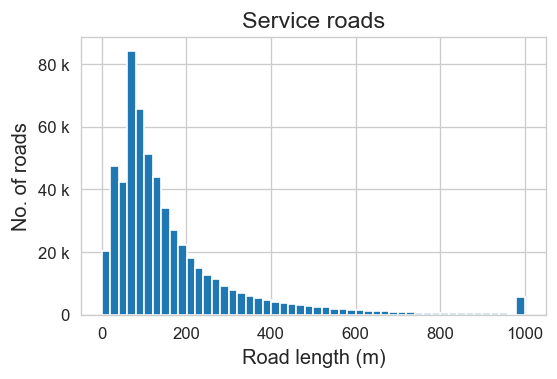

In [85]:
ax = U.plot(size=(5, 3), dpi=120, ylab='No. of roads', xlab='Road length (m)', title='Service roads', yeng=1)
x[x.fclass=='service']['length'].clip(0, 1000).hist(ax=ax, bins=50);

In [99]:
x.cx[minx:maxx, miny:maxy].to_file(P.data / 'export/roads_indy.gpkg')

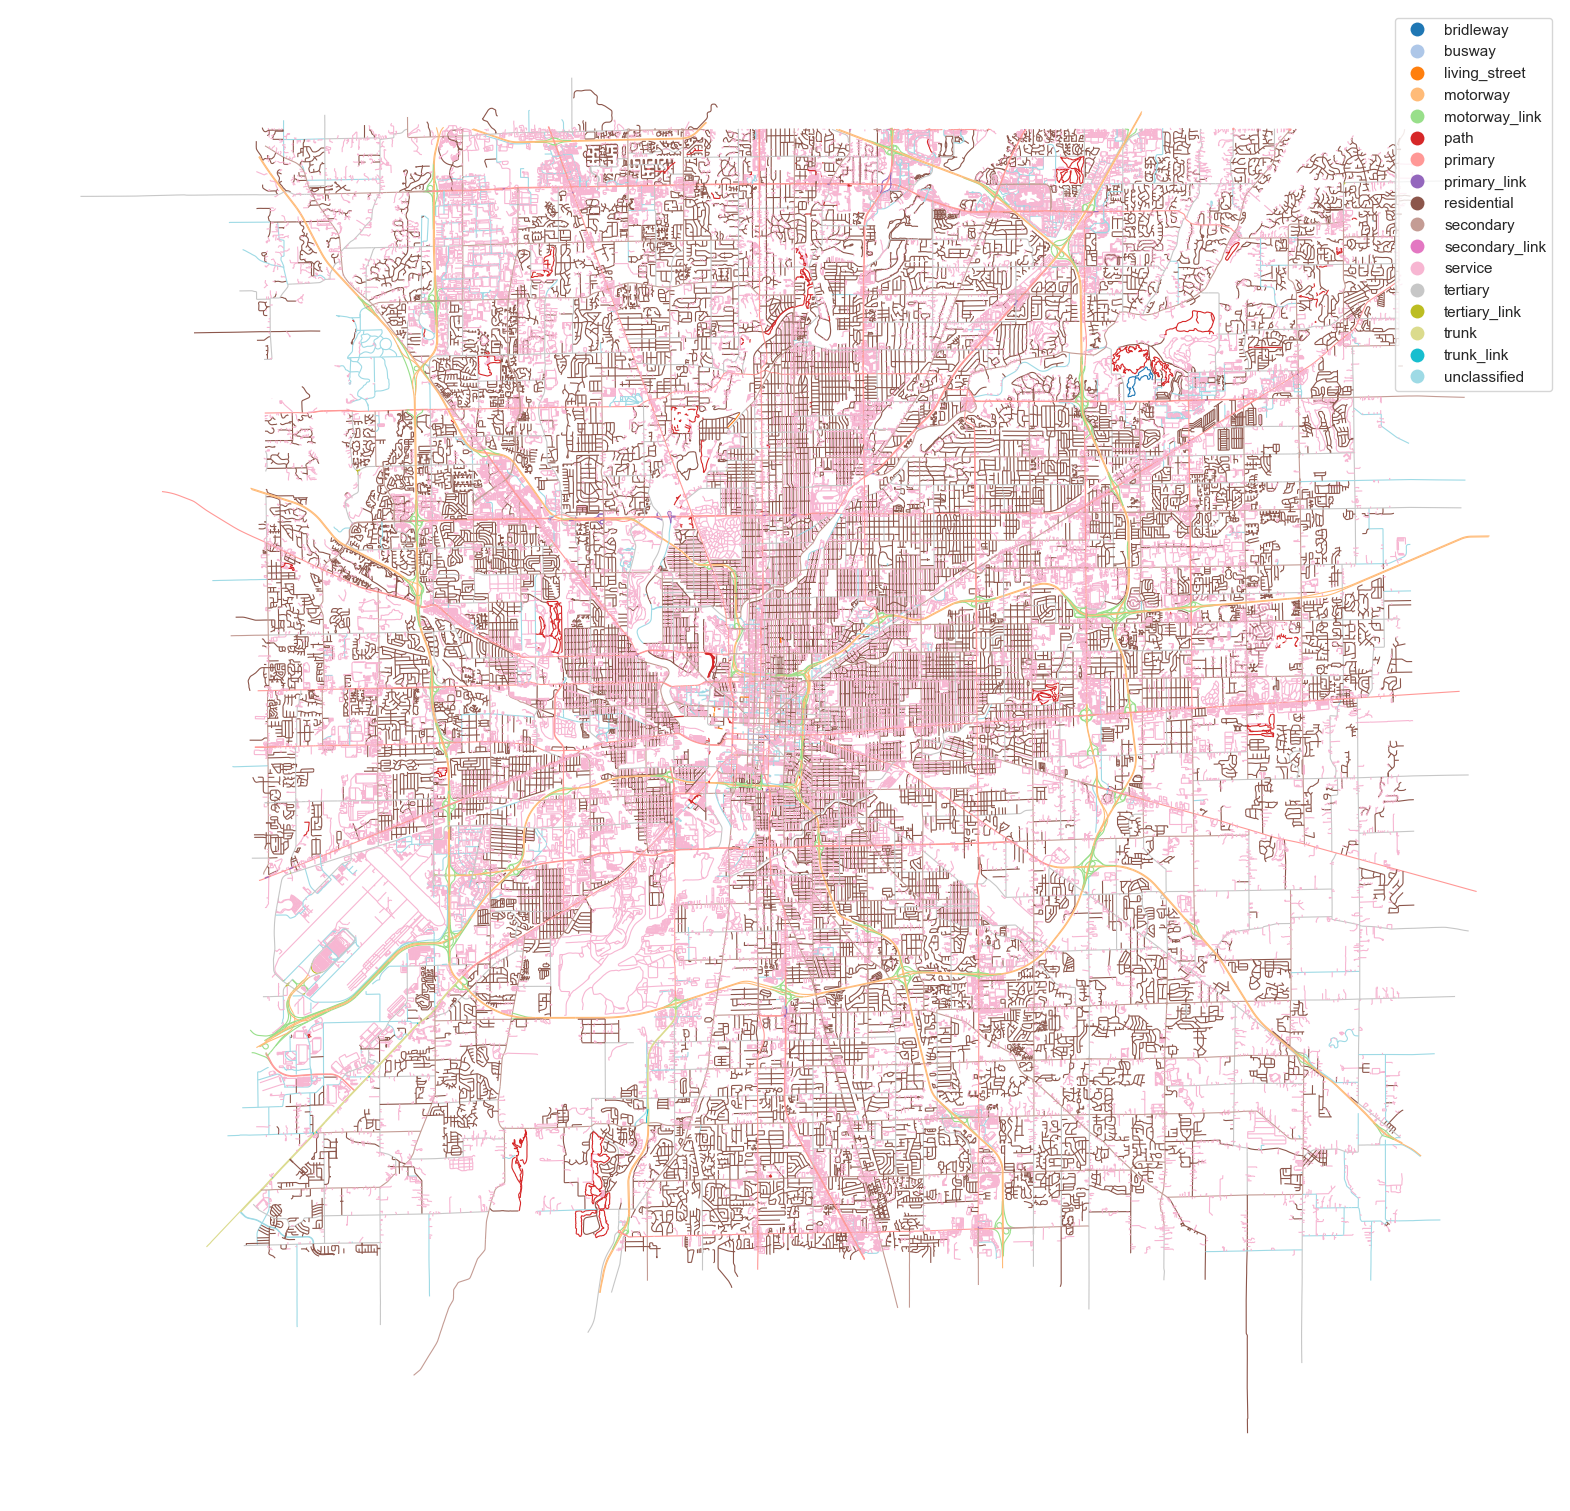

In [97]:
miny, minx = 39.63081410423257, -86.3274139912717
maxy, maxx = 39.92685344181954, -85.93808600872832
ax = U.plot(size=(20, 20), dpi=100, axoff=1)
(x.cx[minx:maxx, miny:maxy]
 .pipe(lambda df: df[~df['fclass'].isin(['footway','cycleway','pedestrian','track','track_grade1','track_grade5','steps'])])
 .plot(ax=ax, column='fclass', legend=True, cmap='tab20', lw=0.8));

### Compute Euclidean reachability

In [30]:
tt_thresholds = np.arange(5, 60+1, 5) * 60

In [31]:
modal_speeds = {k: v * U.MI2M / 3600 for k, v in 
                {'Auto': 40, 'Transit': 25, 'Bike': 14, 'Walk': 3}.items()}

In [32]:
def get_reachability(scales, modal_speeds, tt_thresholds, 
                     metric='euclidean', save=True, overwrite=False):
    outfile = P.data / 'export/poi_access.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    assert metric in ['euclidean', 'road_network']
    pois = gpd.read_parquet(P.data / 'pois/pois.parquet').to_crs(CRS_M)
    res = []
    pbar = tqdm(total=len(scales) * len(modal_speeds) * len(tt_thresholds))
    for scale in scales:
        boundary = gpd.read_parquet(P.data / f'boundary/{scale.lower()}.parquet')
        zones = Gdf(boundary.set_index('geoid').to_crs(CRS_M)
                    .geometry.centroid.rename('centroid')
                    .rename('geometry').reset_index())
        for mode, speed in modal_speeds.items():
            for tt_thresh in tt_thresholds:
                pbar.update()
                radius = speed * tt_thresh
                buffers = Gdf({'geoid': zones['geoid'], 
                              'geometry': zones.buffer(radius)}, crs=CRS_M)
                within = pois.sjoin(buffers, predicate='within')
                df = (within.groupby(['geoid', 'category']).size()
                      .rename('num_pois').reset_index()
                      .assign(scale=scale, mode=mode, tt_thresh=tt_thresh // 60))
                res.append(df)
    id_vars = ['scale', 'mode', 'tt_thresh', 'poi_kind', 'geoid']
    res = (pd.concat(res).reset_index(drop=True)
           .rename(columns={'category': 'poi_kind'})
           .astype({x: 'category' for x in id_vars})[id_vars + ['num_pois']])
    if save:
        res.to_parquet(U.mkfile(outfile))
    return res

%time x = get_reachability(scales[::-1], modal_speeds, tt_thresholds[::-1]); x # t=23:27

CPU times: user 2.2 ms, sys: 3.04 ms, total: 5.23 ms
Wall time: 120 ms


DataFrame[scale: string, mode: string, tt_thresh: bigint, poi_kind: string, geoid: string, num_pois: bigint]

# Miscellaneous

## LEHD/LODES

### Information

In [33]:
with open(P.data / 'lehd/columns.yaml', 'rb') as f:
    lehd_info = yaml.safe_load(f)

### Download data

In [34]:
def download_lehd_lodes(dataset='od', job_type='JT00', state='in', part='main',
                        segment='S000', year=2019, lodes_version=7,
                        aggregate_bg=False, save=True, overwrite=False):
    assert lodes_version in [6, 7]
    assert dataset in ['od', 'rac', 'wac']
    assert part in ['main', 'aux']
    assert job_type in [f'JT{i:02}' for i in range(6)]
    assert segment in 'S000 SA01 SA02 SA03 SE01 SE02 SE03 SI01 SI02 SI03'.split()
    outfile = P.data / f'lehd/lodes/{dataset}.parquet'
    if outfile.exists() and not overwrite:
        return
    root = f'https://lehd.ces.census.gov/data/lodes'
    fname = {'od': f'{state}_od_{part}_{job_type}_{year}',
            'rac': f'{state}_rac_{segment}_{job_type}_{year}',
            'wac': f'{state}_wac_{segment}_{job_type}_{year}'}[dataset]
    url = f'{root}/LODES{lodes_version}/{state}/{dataset}/{fname}.csv.gz'
    df = pd.read_csv(url).drop(columns='createdate', errors='ignore')
    idx_cols = {'od': ['h_geocode', 'w_geocode'],
                'rac': ['h_geocode'], 'wac': ['w_geocode']}[dataset]
    df = df.astype({col: str for col in idx_cols})
    if aggregate_bg:
        for col in idx_cols:
            df[col] = df[col].str.slice(0, 12)
        df = df.groupby(idx_cols).sum().reset_index()
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

download_lehd_lodes('od') # t=0:17
download_lehd_lodes('rac') # t=0:05
download_lehd_lodes('wac') # t=0:03

## Economic Tracker
GitHub: https://github.com/OpportunityInsights/EconomicTracker

In [35]:
def download_oi_ecotracker_data(overwrite=False):
    url = 'https://github.com/OpportunityInsights/EconomicTracker/archive/main.zip'
    outfile = P.data / 'economic_tracker/raw_data.zip'
    if outfile.exists() and not overwrite:
        return
    urllib.request.urlretrieve(url, U.mkfile(outfile))

x = download_oi_ecotracker_data(); x # t=0:22